<a href="https://colab.research.google.com/github/Dimas263/NLP_BILSTM_Named-Entity_Recognition/blob/main/BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://img.icons8.com/external-flaticons-lineal-color-flat-icons/64/undefined/external-big-data-smart-technology-flaticons-lineal-color-flat-icons-2.png"/> **NLP Research<br>BiLSTM Named Entity Recognition**
## <img src="https://img.icons8.com/external-fauzidea-flat-fauzidea/64/undefined/external-man-avatar-avatar-fauzidea-flat-fauzidea.png"/> **`Dimas Dwi Putra`**

# **Model BILSTM ARCHITECTURE**

<center>

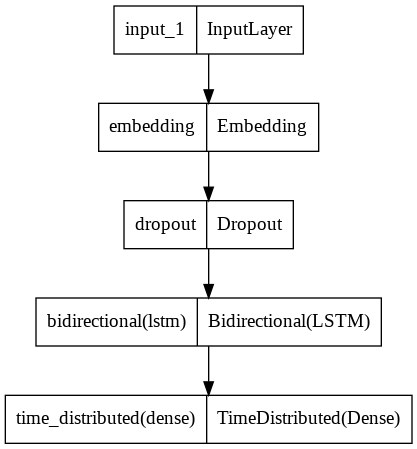

</center>

# **Source Code And Output**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install tensorflow
! pip install keras==0.23.1
! pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
! pip install sklearn-crfsuite
! pip install seqeval
! pip install numpy==1.19.5

In [ ]:
import os
import numpy as np 
import pandas as pd
import tensorflow

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from itertools import chain
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.utils import plot_model

from numpy.random import seed

In [ ]:
for dirname, _, filenames in os.walk('/content/drive/MyDrive/bert_bilstm_crf_named_entity_recognition/BILSTM-NER/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/bert_bilstm_crf_named_entity_recognition/BILSTM-NER/input/ner_dataset.csv', encoding= 'unicode_escape')

In [ ]:
df.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 0,studies,NNS,O
1,Sentence: 0,on,IN,O
2,Sentence: 0,magnesium,NN,O
3,Sentence: 0,s,NN,O
4,Sentence: 0,mechanism,NN,O
5,Sentence: 0,of,IN,O
6,Sentence: 0,action,NN,O
7,Sentence: 0,in,IN,O
8,Sentence: 0,digitalis,NN,plant
9,Sentence: 0,induced,VBD,O


In [ ]:
df.tail(20)

,Sentence #,Word,POS,Tag
38185,Sentence: 1309,use,NN,O
38186,Sentence: 1309,these,DT,O
38187,Sentence: 1309,findings,NNS,O
38188,Sentence: 1309,suggest,VBP,O
38189,Sentence: 1309,that,IN,O
38190,Sentence: 1309,part,NN,O
38191,Sentence: 1309,of,IN,O
38192,Sentence: 1309,the,DT,O
38193,Sentence: 1309,association,NN,O
38194,Sentence: 1309,between,IN,O


In [ ]:
df.nunique()

Sentence #    1310
Word          3089
POS             32
Tag              3
dtype: int64

In [ ]:
def get_sentences(dataset):
    agg_func = lambda s:[(w,p,t) for w,p,t in zip(s["Word"].values.tolist(),
                                                 s["POS"].values.tolist(),
                                                 s["Tag"].values.tolist())]
    grouped = dataset.groupby("Sentence #").apply(agg_func)
    sentences = [s for s in grouped]
    return sentences

In [ ]:
sentences = get_sentences(df)
sentences[1]

[('the', 'DT', 'O'),
 ('mechanism', 'NN', 'O'),
 ('by', 'IN', 'O'),
 ('which', 'WDT', 'O'),
 ('magnesium', 'NN', 'O'),
 ('affects', 'VBZ', 'O'),
 ('digitalis', 'RB', 'plant'),
 ('induced', 'JJ', 'O'),
 ('arrhythmias', 'NN', 'disease'),
 ('was', 'VBD', 'O'),
 ('studied', 'VBN', 'O'),
 ('in', 'IN', 'O'),
 ('dogs', 'NNS', 'O'),
 ('with', 'IN', 'O'),
 ('and', 'CC', 'O'),
 ('without', 'IN', 'O'),
 ('beta', 'NN', 'O'),
 ('receptor', 'NN', 'O')]

In [ ]:
def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(df['Word'].to_list()))
    else:
        vocab = list(set(df['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok


token2idx, idx2token = get_dict_map(df, 'token')
tag2idx, idx2tag = get_dict_map(df, 'tag')

In [ ]:
df['Word_idx'] = df['Word'].map(token2idx)
df['Tag_idx'] = df['Tag'].map(tag2idx)
data_fillna = df.fillna(method='ffill', axis=0)
data_group = data_fillna.groupby(['Sentence #'],as_index=False
                                )['Word', 'POS', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

data_group.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 0,"[studies, on, magnesium, s, mechanism, of, act...","[NNS, IN, NN, NN, NN, IN, NN, IN, NN, VBD, NNS]","[O, O, O, O, O, O, O, O, plant, O, disease]","[2506, 268, 2067, 2597, 713, 177, 1584, 2671, ...","[2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 0]"
1,Sentence: 1,"[the, mechanism, by, which, magnesium, affects...","[DT, NN, IN, WDT, NN, VBZ, RB, JJ, NN, VBD, VB...","[O, O, O, O, O, O, plant, O, disease, O, O, O,...","[2387, 713, 386, 1557, 2067, 2158, 908, 1578, ...","[2, 2, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, ..."
2,Sentence: 10,"[these, observations, indicate, that, oral, ad...","[DT, NNS, VBP, IN, JJ, NN, IN, JJ, JJ, NN, NN,...","[O, O, O, O, O, O, O, plant, plant, plant, pla...","[889, 554, 1917, 394, 601, 1499, 177, 2953, 29...","[2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, ..."
3,Sentence: 100,"[the, lack, of, association, of, the, nude, mi...","[DT, NN, IN, NN, IN, DT, JJ, NN, NNS, NNS, NN,...","[O, O, O, O, O, O, O, O, disease, disease, O, ...","[2387, 1398, 177, 938, 177, 2387, 822, 1340, 6...","[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, ..."
4,Sentence: 1000,"[remarkably, daily, oral, feeding, of, 100, mg...","[RB, JJ, JJ, NN, IN, CD, NNS, VBD, NN, NN, IN,...","[O, O, O, O, O, O, O, O, O, O, O, plant, O, O,...","[2125, 1694, 601, 2774, 177, 2142, 1581, 2030,...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, ..."


In [ ]:
seqs_length = [len(s) for s in sentences]
max_seq_length = max(seqs_length)
print(f"Max sequence length: {max_seq_length}")

words = list(df['Word'].unique())
words.append("[PAD]")
num_words = len(words)
print(f"Number of words: {num_words}")

tags = list(df['Tag'].unique())
num_tags = len(tags)
print(f"Number of tags: {num_tags}")

Max sequence length: 137
Number of words: 3090
Number of tags: 3


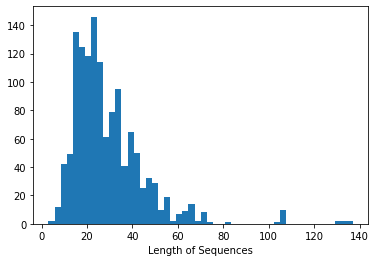

In [ ]:
plt.hist(seqs_length,bins= 50)
plt.xlabel("Length of Sequences")
plt.show()

In [ ]:
word2idx = {word: idx for idx, word in enumerate(words)}
tag2idx = {tag: idx for idx, tag in enumerate(tags)}

In [ ]:
from keras.preprocessing.sequence import pad_sequences

X = [[word2idx[w[0]] for w in s] for s in sentences]
y = [[tag2idx[w[2]] for w in s] for s in sentences]

paddedX = pad_sequences(maxlen = max_seq_length,sequences = X,padding = 'post',value = num_words-1)
paddedY = pad_sequences(maxlen = max_seq_length,sequences = y,padding = 'post',value = tag2idx['O'])

from tensorflow.keras.utils import to_categorical
X = paddedX
y = [to_categorical(i,num_classes = num_tags) for i in paddedY]

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.1,random_state=1)

In [ ]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional

_input = Input(shape=(max_seq_length,))
_embed = Embedding(input_dim=num_words, output_dim=max_seq_length, input_length=max_seq_length)(_input)
_embed = Dropout(0.1)(_embed)
_arch = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(_embed)
_output = TimeDistributed(Dense(num_tags, activation="softmax"))(_arch)  # softmax output layer


model = Model(_input, _output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 137)]             0         
                                                                 
 embedding (Embedding)       (None, 137, 137)          423330    
                                                                 
 dropout (Dropout)           (None, 137, 137)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 137, 200)         190400    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 137, 3)           603       
 ibuted)                                                         
                                                                 
Total params: 614,333
Trainable params: 614,333
Non-trainable

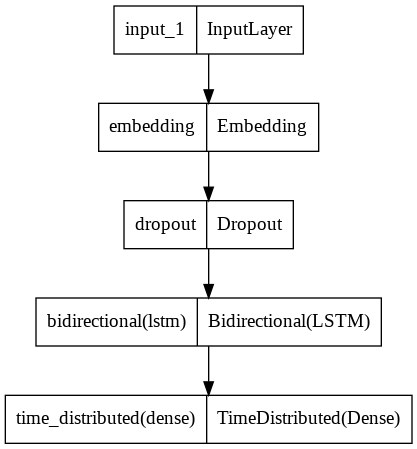

In [ ]:
plot_model(model)

In [ ]:
from keras import backend as K

def recall_scores(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_scores(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_scores(y_true, y_pred):
    precision = precision_scores(y_true, y_pred)
    recall = recall_scores(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['accuracy', f1_scores, precision_scores, recall_scores])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 


early_stopping = EarlyStopping(monitor = 'val_accuracy',patience =2,verbose = 0,mode = 'max',restore_best_weights = False)
callbacks = [early_stopping]

history = model.fit(
    x_train,np.array(y_train),
    validation_split =0.2,
    batch_size = 32,
    epochs = 3,
    verbose =1
)

Epoch 1/3
30/30 [==============================] - 25s 650ms/step - loss: 0.3238 - accuracy: 0.9557 - f1_scores: 0.8218 - precision_scores: 0.8398 - recall_scores: 0.8087 - val_loss: 0.1282 - val_accuracy: 0.9662 - val_f1_scores: 0.9663 - val_precision_scores: 0.9663 - val_recall_scores: 0.9663
Epoch 2/3
30/30 [==============================] - 23s 774ms/step - loss: 0.1218 - accuracy: 0.9648 - f1_scores: 0.9649 - precision_scores: 0.9649 - recall_scores: 0.9649 - val_loss: 0.1099 - val_accuracy: 0.9662 - val_f1_scores: 0.9663 - val_precision_scores: 0.9663 - val_recall_scores: 0.9663
Epoch 3/3
30/30 [==============================] - 19s 627ms/step - loss: 0.1085 - accuracy: 0.9648 - f1_scores: 0.9650 - precision_scores: 0.9651 - recall_scores: 0.9648 - val_loss: 0.1002 - val_accuracy: 0.9662 - val_f1_scores: 0.9663 - val_precision_scores: 0.9663 - val_recall_scores: 0.9663


In [ ]:
model.evaluate(x_test,np.array(y_test))
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test,np.array(y_test), verbose=0)

5/5 [==============================] - 0s 81ms/step - loss: 0.0924 - accuracy: 0.9689 - f1_scores: 0.9714 - precision_scores: 0.9714 - recall_scores: 0.9714


In [ ]:
print(f"Loss : {loss}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"Accuracy : {accuracy}")
print(f"F-1 Score : {f1_score}")

Loss : 0.09244067221879959
Precision : 0.9714112281799316
Recall : 0.9714112281799316
Accuracy : 0.9688527584075928
F-1 Score : 0.9714111089706421


In [ ]:
model.save('/content/drive/MyDrive/bert_bilstm_crf_named_entity_recognition/BILSTM-NER/output/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/bert_bilstm_crf_named_entity_recognition/BILSTM-NER/output/model/assets
